# CAP 6619 - Deep Learning
## Assignment 5
## Image classification using the CIFAR-10 dataset

Inspired by:

https://www.kaggle.com/c/cifar-10

https://keras.io/examples/vision/metric_learning/

https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer


### Setup

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

import random

import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers

### Part 1: Load dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the image data
x_train = x_train.astype("float32") / 255.0
y_train = np.squeeze(y_train)

x_test = x_test.astype("float32") / 255.0
y_test = np.squeeze(y_test)

170508288/170498071 [==============================] - 2s 0us/step


### Part 2: Explore dataset

In [ ]:
# Number of samples
print("Number of training sample: ",y_train.shape[0])
print("Number of test samples: ", y_test.shape[0])

Number of training sample:  50000
Number of test samples:  10000


In [ ]:
# Number of classes
num_classes = max(y_test)+1
print(num_classes)

10


In [ ]:
# Shape of image data
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


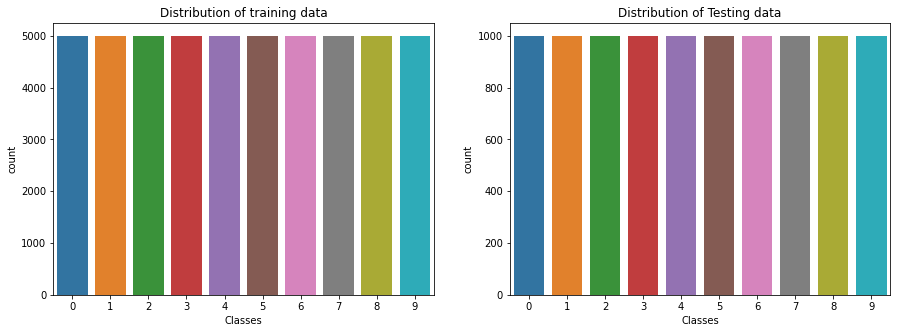

In [ ]:
# Distribution of classes in training samples

fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

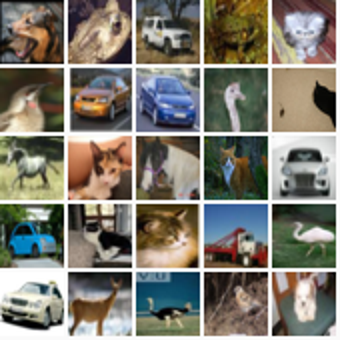

In [ ]:
# Show collage of 25 (randomly selected) images

height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


# Show a collage of 5x5 random images.
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

In [ ]:
idx = y_train[0]
print(idx)

6


In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [ ]:
labels[idx]

'Frog'

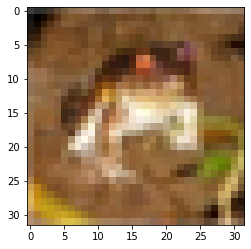

In [ ]:
plt.imshow(x_train[0])

In [ ]:
# Convert class vectors to binary class matrices. 
# This is called one-hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

### Part 3: Build your 1st model

In this case we will start by using a convolutional neural network (CNN) built from scratch. 


In [ ]:
batch_size = 128
epochs = 40
data_augmentation = False

In [ ]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTEN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [ ]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Part 4: Train your first model

In [ ]:
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/40
391/391 [==============================] - 54s 17ms/step - loss: 2.1096 - accuracy: 0.2174 - val_loss: 1.7278 - val_accuracy: 0.3896
Epoch 2/40
391/391 [==============================] - 5s 14ms/step - loss: 1.6993 - accuracy: 0.3850 - val_loss: 1.5339 - val_accuracy: 0.4495
Epoch 3/40
391/391 [==============================] - 6s 14ms/step - loss: 1.5764 - accuracy: 0.4329 - val_loss: 1.4338 - val_accuracy: 0.4867
Epoch 4/40
391/391 [==============================] - 6s 15ms/step - loss: 1.4972 - accuracy: 0.4545 - val_loss: 1.4059 - val_accuracy: 0.5010
Epoch 5/40
391/391 [==============================] - 5s 14ms/step - loss: 1.4261 - accuracy: 0.4852 - val_loss: 1.3237 - val_accuracy: 0.5247
Epoch 6/40
391/391 [==============================] - 5s 14ms/step - loss: 1.3611 - accuracy: 0.5129 - val_loss: 1.2876 - val_accuracy: 0.5415
Epoch 7/40
391/391 [==============================] - 6s 15ms/step - loss: 1.3141 - accuracy: 0.5248 - val_loss: 1.2106 - val_accuracy: 0.570

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


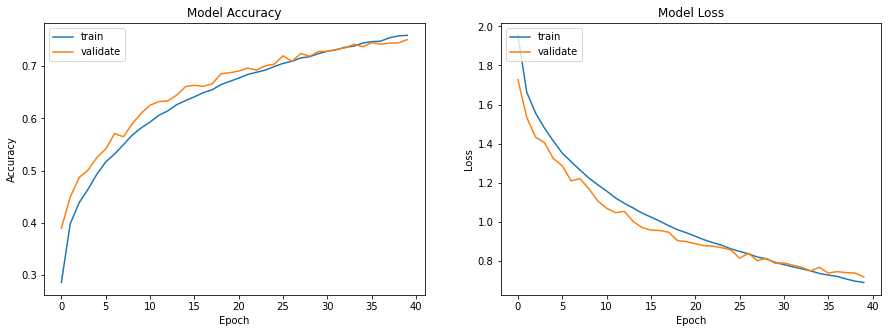

In [ ]:
plotmodelhistory(history)

### Part 5: Evaluate your 1st model

In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.7202 - accuracy: 0.7509
Test loss: 0.7202193737030029
Test accuracy: 0.7508999705314636


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

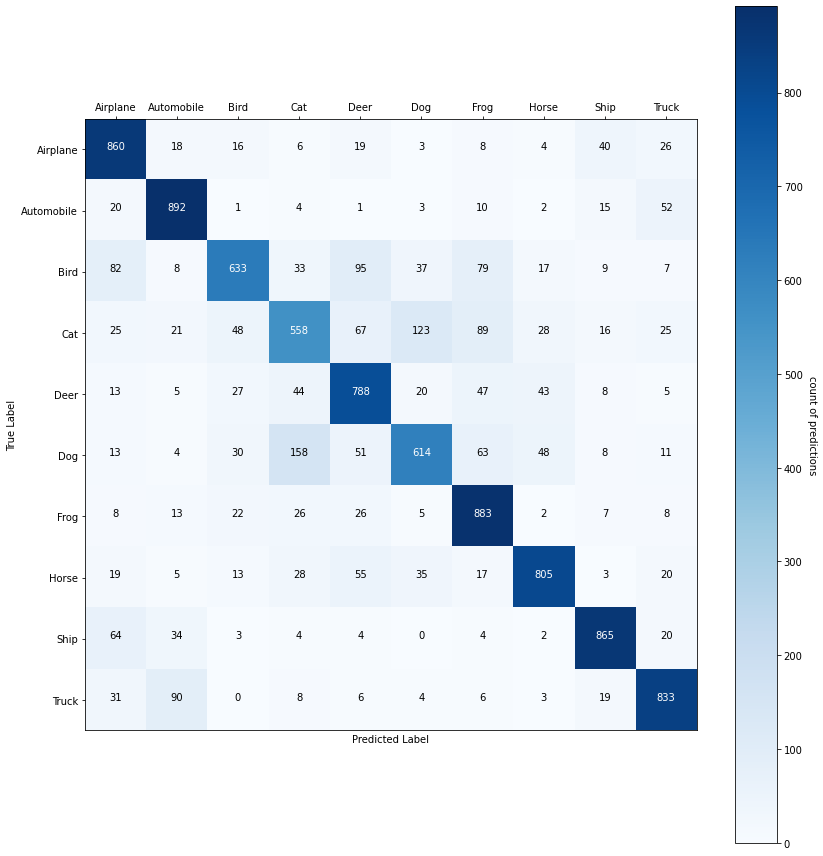

In [ ]:
# Plot confusion matrix

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

QUESTION 1: Which classes are more likely to be misclassified by this model?Does this make intuitive sense?

Bird cat and dog have low predicted value. Cat has lowest recall value. Recall coorelate with this as a artifact of validation.  precision is the lowest values in the labels mentioned. Meaning that it has a high misclassification rate.I also validated in the confusion matrix with normalization and also  validated there was seeing some results. It does make sense because the  value are reflecting the misclassification.

In [ ]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      1000
           1       0.82      0.89      0.85      1000
           2       0.80      0.63      0.71      1000
           3       0.64      0.56      0.60      1000
           4       0.71      0.79      0.75      1000
           5       0.73      0.61      0.67      1000
           6       0.73      0.88      0.80      1000
           7       0.84      0.81      0.82      1000
           8       0.87      0.86      0.87      1000
           9       0.83      0.83      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



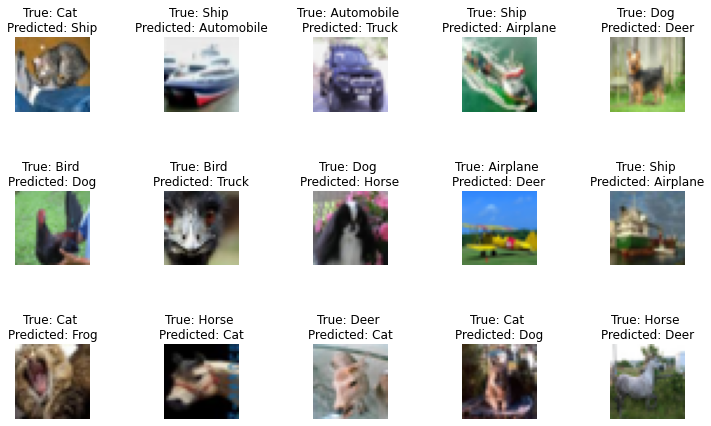

In [ ]:
# Inspect errors
R = 3
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(x_test[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [ ]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(x_test[number], axis=0)
    test_result = model.predict_classes(test_image)
    plt.imshow(x_test[number])
    dict_key = test_result[0]
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],
                                                      labels[Y_true[number]]))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


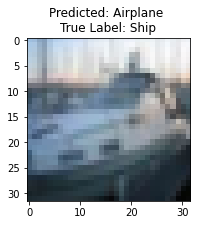

In [ ]:
show_test(2)

### Part 6: Transfer Learning

#### Transfer Learning: setup

In [ ]:
from keras import Sequential
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
#Import dataset (again)
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [ ]:
#Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


#### Attempt #1: using ResNet50 as a base model 

Learn more about ResNet50 at: https://www.kaggle.com/keras/resnet50 

In [ ]:
base_model_1 = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(32,32,3),
                        classes=y_train.shape[1])

model_1=Sequential()
#Add the Dense layers along with activation and batch normalization
model_1.add(base_model_1)
model_1.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(4000,activation=('relu'),input_dim=512))
model_1.add(Dense(2000,activation=('relu'))) 
model_1.add(Dense(1000,activation=('relu'))) 
model_1.add(Dense(500,activation=('relu')))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [ ]:
batch_size= 128
epochs=10
learn_rate=.003

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [ ]:
# Compile the model
model_1.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Train the model
history_1 = model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose = 1,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/10
274/274 [==============================] - 43s 97ms/step - loss: 1.6536 - accuracy: 0.4092 - val_loss: 1.2166 - val_accuracy: 0.6009
Epoch 2/10
274/274 [==============================] - 24s 87ms/step - loss: 0.7066 - accuracy: 0.7577 - val_loss: 0.7456 - val_accuracy: 0.7498
Epoch 3/10
274/274 [==============================] - 26s 96ms/step - loss: 0.4354 - accuracy: 0.8527 - val_loss: 0.7975 - val_accuracy: 0.7413
Epoch 4/10
274/274 [==============================] - 26s 95ms/step - loss: 0.2857 - accuracy: 0.9033 - val_loss: 0.8267 - val_accuracy: 0.7547
Epoch 5/10
274/274 [==============================] - 24s 87ms/step - loss: 0.2007 - accuracy: 0.9334 - val_loss: 0.8976 - val_accuracy: 0.7477
Epoch 6/10
274/274 [==============================] - 26s 96ms/step - loss: 0.1396 - accuracy: 0.9547 - val_loss: 1.0633 - val_accuracy: 0.7425
Epoch 7/10
274/274 [==============================] - 26s 96ms/step - loss: 0.1162 - accuracy: 0.9601 - val_loss: 1.0910 - val_accuracy:

In [ ]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


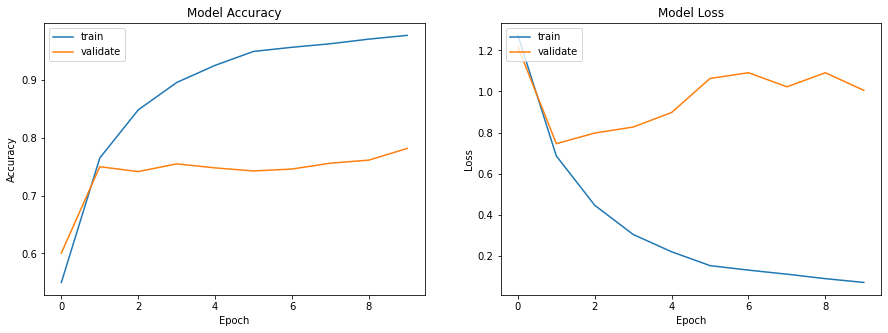

In [ ]:
plotmodelhistory(history_1)

In [ ]:
# Score trained model.
scores = model_1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_1.predict(x_test)

313/313 [==============================] - 6s 18ms/step - loss: 1.0684 - accuracy: 0.7731
Test loss: 1.0683774948120117
Test accuracy: 0.7731000185012817


In [ ]:
  def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [ ]:
y_pred=model_1.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization


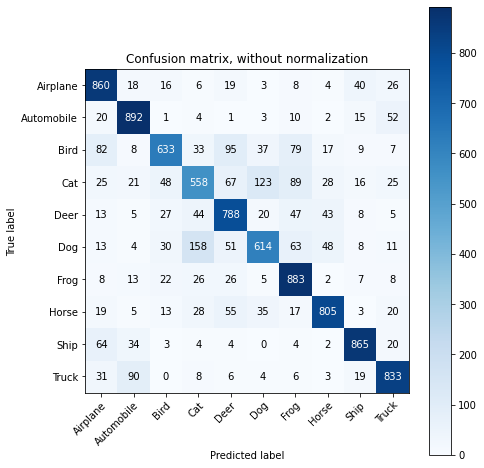

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


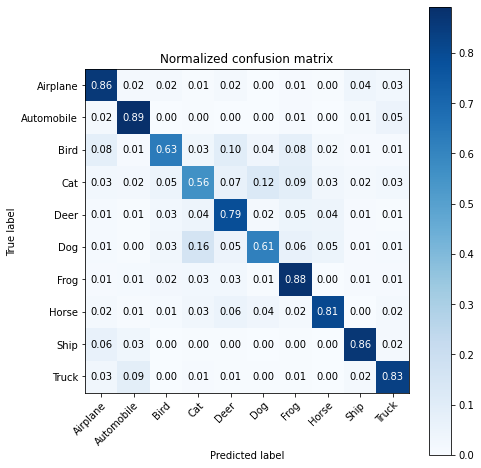

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

#### Attempt #2: Your turn!

Write code to build, train, and evaluate *another* transfer learning model.

Here are a few things you could do:
*   Use a different base model, e.g., VGG19 (see https://www.kaggle.com/keras/vgg19)
*   Add Dropout layers
*   Use data augmentation
*   Change optimizer
*   Change other hyperparameters (learning rate, batch size, etc.)









#####Asam Mahmood Solutions

The code below uses the same base model and simply changes optimizer and other hyperparameters.

In [ ]:
base_model_4 = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(32,32,3),
                        classes=y_train.shape[1])

model_4=Sequential()
#Add the Dense layers along with activation and batch normalization
model_4.add(base_model_4)
model_4.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_4.add(Dense(4000,activation=('relu'),input_dim=512))
model_4.add(Dense(2000,activation=('relu'))) 
model_4.add(Dense(1000,activation=('relu'))) # hyper
model_4.add(Dense(500,activation=('relu')))
model_4.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [ ]:
# Compile the model
batch_size= 128
epochs=10
learn_rate=.001

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

model_4.compile(optimizer=adam, # hyper
                loss='categorical_crossentropy', # hyper
                metrics=['accuracy'])

In [ ]:
# Train the model
history_4 = model_4.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True)

Epoch 1/10
274/274 [==============================] - 36s 102ms/step - loss: 2.0489 - accuracy: 0.3093 - val_loss: 3.2908 - val_accuracy: 0.4487
Epoch 2/10
274/274 [==============================] - 24s 88ms/step - loss: 0.9485 - accuracy: 0.7028 - val_loss: 1.3182 - val_accuracy: 0.6283
Epoch 3/10
274/274 [==============================] - 24s 87ms/step - loss: 0.7054 - accuracy: 0.7780 - val_loss: 1.9445 - val_accuracy: 0.6597
Epoch 4/10
274/274 [==============================] - 24s 87ms/step - loss: 0.6181 - accuracy: 0.8055 - val_loss: 1.0758 - val_accuracy: 0.6685
Epoch 5/10
274/274 [==============================] - 24s 87ms/step - loss: 0.4951 - accuracy: 0.8411 - val_loss: 1.1307 - val_accuracy: 0.6673
Epoch 6/10
274/274 [==============================] - 26s 97ms/step - loss: 0.4840 - accuracy: 0.8501 - val_loss: 1.1134 - val_accuracy: 0.6853
Epoch 7/10
274/274 [==============================] - 24s 87ms/step - loss: 0.5274 - accuracy: 0.8375 - val_loss: 0.8501 - val_accuracy

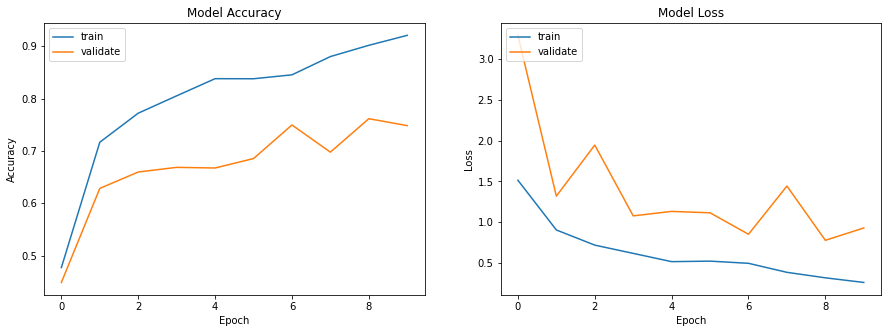

In [ ]:
plotmodelhistory(history_4)

In [ ]:
# Score trained model.
scores = model_4.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_4.predict(x_test)

313/313 [==============================] - 5s 17ms/step - loss: 0.9176 - accuracy: 0.7473
Test loss: 0.9175867438316345
Test accuracy: 0.7473000288009644


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix, without normalization


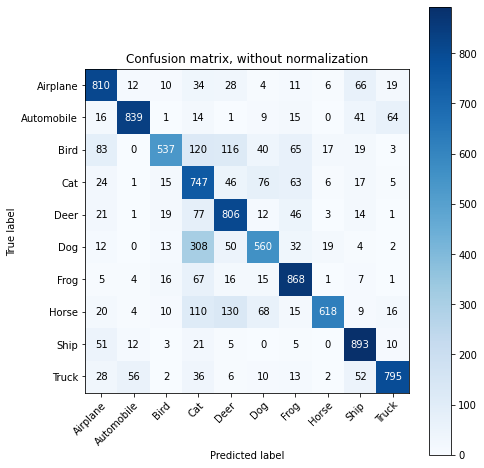

In [ ]:
y_pred=model_4.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

#Compute the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


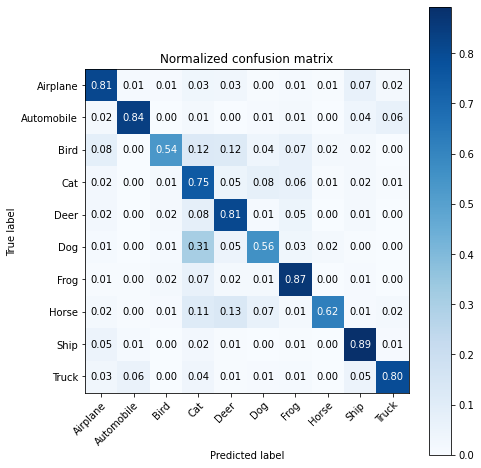

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')
# plt.show()

Epoch 1/5
274/274 [==============================] - 32s 91ms/step - loss: 2.2599 - accuracy: 0.2122 - val_loss: 5.2810 - val_accuracy: 0.3005
Epoch 2/5
274/274 [==============================] - 26s 97ms/step - loss: 1.3238 - accuracy: 0.5057 - val_loss: 1.5883 - val_accuracy: 0.5602
Epoch 3/5
274/274 [==============================] - 24s 88ms/step - loss: 0.8989 - accuracy: 0.7004 - val_loss: 1.8432 - val_accuracy: 0.5407
Epoch 4/5
274/274 [==============================] - 26s 96ms/step - loss: 0.7548 - accuracy: 0.7571 - val_loss: 0.8824 - val_accuracy: 0.7275
Epoch 5/5
313/313 [==============================] - 5s 17ms/step - loss: 0.9176 - accuracy: 0.7473
Test loss: 0.9175867438316345
Test accuracy: 0.7473000288009644


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


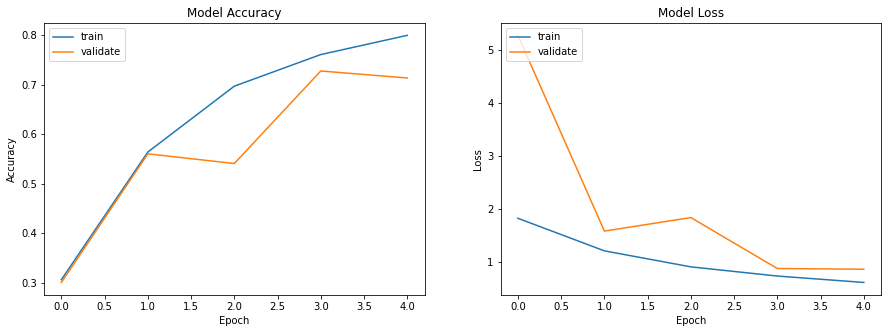

Confusion matrix, without normalization
Normalized confusion matrix


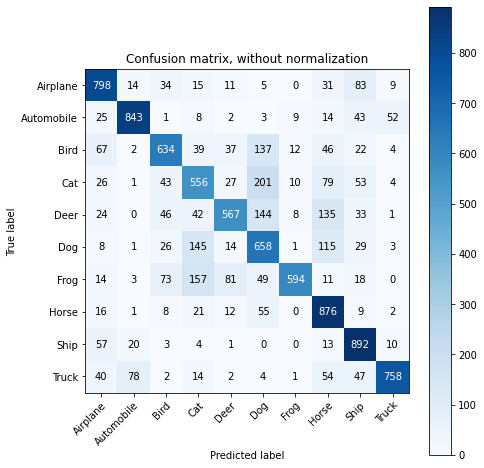

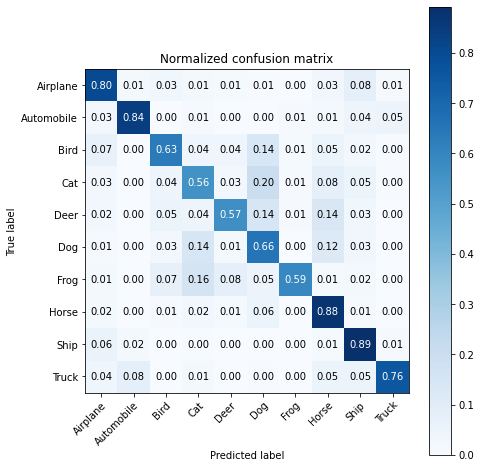

In [ ]:

class optional_2A:
    def __init__(self, x, y, y_val ,x_val , x_test, y_test, learn_rate,labels):
        self.x_train =x
        self.y_train =y
        self.y_val =y_val
        self.x_val =x_val
        self.x_test =x_test
        self.y_test =y_test
        self.learn_rate = learn_rate
        self.labels = labels

        self.buildWhole()

    def buildWhole(self):
        self.build()
        self.modelbuild()
        self.batchset()
        self.compileModel()
        self.plota()
        self.plotb()

    def build(self):
        self.base_model_4 = ResNet50(include_top=False,
                                weights='imagenet',
                                input_shape=(32,32,3),
                                classes=self.y_train.shape[1])

    def modelbuild(self):
        self.model_4=Sequential()
        #Add the Dense layers along with activation and batch normalization
        self.model_4.add(self.base_model_4)
        self.model_4.add(Flatten())

        #Add the Dense layers along with activation and batch normalization
        self.model_4.add(Dense(4000,activation=('relu'),input_dim=512))
        self.model_4.add(Dense(2000,activation=('relu')))
        self.model_4.add(Dense(1000,activation=('relu')))
        self.model_4.add(Dense(500,activation=('relu')))
        self.model_4.add(Dense(10,activation=('softmax'))) #This is the classification layer

    def batchset(self):
        # Compile the model
        self.batch_size= 128
        self.epochs=5
        self.learn_rate=.001

        self.sgd=SGD(learning_rate=self.learn_rate,momentum=.9,nesterov=False)
        self.adam=Adam(learning_rate=self.learn_rate)

    def compileModel(self):
        self.model_4.compile(optimizer=self.adam,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


        # Train the model
        self.history_4 = self.model_4.fit(self.x_train, self.y_train,
                      batch_size=self.batch_size,
                      epochs=self.epochs,
                      validation_data=(self.x_val, self.y_val),
                      shuffle=True)
                      
        # Score trained model.
        self.scores = model_4.evaluate(self.x_test, self.y_test, verbose=1)
        print('Test loss:', self.scores[0])
        print('Test accuracy:', self.scores[1])
        # make prediction.
        self.pred = self.model_4.predict(self.x_test)

        self.y_pred=self.model_4.predict_classes(self.x_test)
        self.y_true=np.argmax(self.y_test,axis=1)

        #Compute the confusion matrix
        self.confusion_mtx=confusion_matrix(self.y_true,self.y_pred)
        plotmodelhistory(self.history_4)
    def plota(self):

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(self.y_true, self.y_pred, classes=self.labels,
                              title='Confusion matrix, without normalization')

    def plotb(self):

        # Plot normalized confusion matrix
        plot_confusion_matrix(self.y_true, self.y_pred, classes=self.labels, normalize=True,
                              title='Normalized confusion matrix')

    def plot_confusion_matrix(y_true, y_pred, classes,
                            normalize=False,
                            title=None,
                            cmap=plt.cm.Blues):
      """
      This function prints and plots the confusion matrix.
      Normalization can be applied by setting `normalize=True`.
      """
      if not title:
          if normalize:
              title = 'Normalized confusion matrix'
          else:
              title = 'Confusion matrix, without normalization'

      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred)
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')

  #     print(cm)

      fig, ax = plt.subplots(figsize=(7,7))
      im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
      ax.figure.colorbar(im, ax=ax)
      # We want to show all ticks...
      ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

      # Rotate the tick labels and set their alignment.
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")
      # Loop over data dimensions and create text annotations.
      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
              ax.text(j, i, format(cm[i, j], fmt),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
      return ax

# good performance example
optional_2A(x_train,y_train,y_val,x_val, x_test, y_test, learn_rate,labels)

Epoch 1/5
274/274 [==============================] - 33s 93ms/step - loss: 2.8332 - accuracy: 0.1100 - val_loss: 2.2179 - val_accuracy: 0.1715
Epoch 2/5
274/274 [==============================] - 26s 97ms/step - loss: 2.0779 - accuracy: 0.1746 - val_loss: 1.9247 - val_accuracy: 0.1838
Epoch 3/5
274/274 [==============================] - 26s 96ms/step - loss: 1.9029 - accuracy: 0.2014 - val_loss: 1.8901 - val_accuracy: 0.2311
Epoch 4/5
274/274 [==============================] - 26s 96ms/step - loss: 1.8477 - accuracy: 0.2449 - val_loss: 2.4801 - val_accuracy: 0.1517
Epoch 5/5
313/313 [==============================] - 5s 17ms/step - loss: 0.9176 - accuracy: 0.7473
Test loss: 0.9175867438316345
Test accuracy: 0.7473000288009644


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


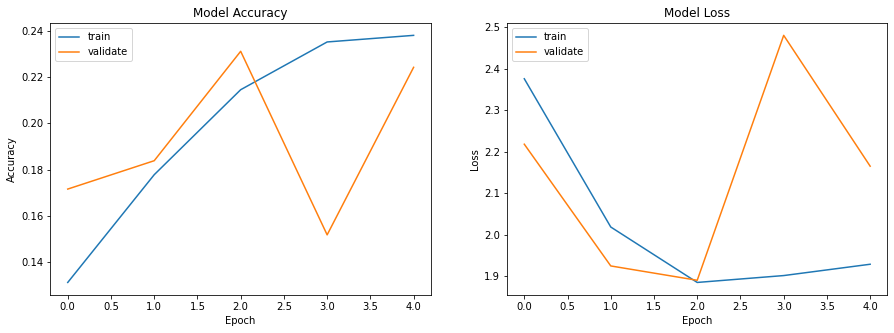

Confusion matrix, without normalization
Normalized confusion matrix


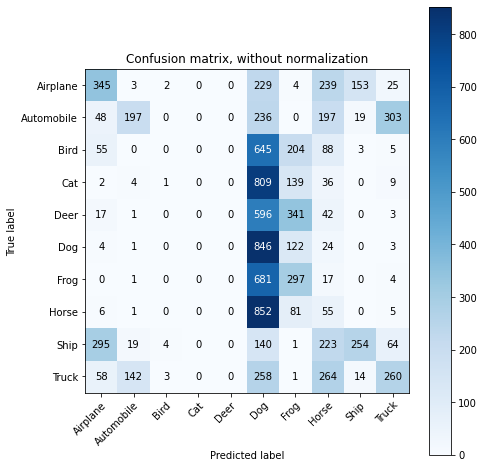

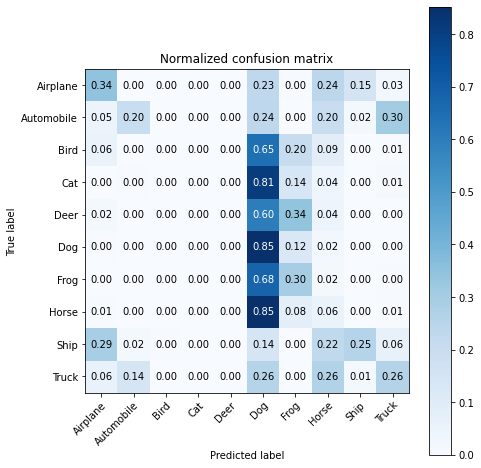

In [ ]:

class optional_2B:
    def __init__(self, x, y, y_val ,x_val , x_test, y_test, learn_rate,labels):
        self.x_train =x
        self.y_train =y
        self.y_val =y_val
        self.x_val =x_val
        self.x_test =x_test
        self.y_test =y_test
        self.learn_rate = learn_rate
        self.labels = labels

        self.buildWhole()

    def buildWhole(self):
        self.build()
        self.modelbuild()
        self.batchset()
        self.compileModel()
        self.plota()
        self.plotb()

    def build(self):
        self.base_model_4 = ResNet50(include_top=False,
                                weights='imagenet',
                                input_shape=(32,32,3),
                                classes=self.y_train.shape[1])

    def modelbuild(self):
        self.model_4=Sequential()
        #Add the Dense layers along with activation and batch normalization
        self.model_4.add(self.base_model_4)
        self.model_4.add(Flatten())

        #Add the Dense layers along with activation and batch normalization
        self.model_4.add(Dense(4000,activation=('relu'),input_dim=512))
        self.model_4.add(Dense(1000,activation=('sigmoid')))
        self.model_4.add(Dense(1000,activation=('sigmoid')))
        self.model_4.add(Dense(500,activation=('sigmoid')))
        self.model_4.add(Dense(1000,activation=('sigmoid')))
        self.model_4.add(Dense(1000,activation=('softplus')))
        self.model_4.add(Dense(1000,activation=('softplus')))
        self.model_4.add(Dense(1000,activation=('softplus')))

        self.model_4.add(Dense(10,activation=('softmax'))) #This is the classification layer

    def batchset(self):
        # Compile the model
        self.batch_size= 128
        self.epochs=5
        self.learn_rate=.001

        self.sgd=SGD(learning_rate=self.learn_rate,momentum=.9,nesterov=False)
        self.adam=Adam(learning_rate=self.learn_rate)

    def compileModel(self):
        self.model_4.compile(optimizer=self.adam,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


        # Train the model
        self.history_4 = self.model_4.fit(self.x_train, self.y_train,
                      batch_size=self.batch_size,
                      epochs=self.epochs,
                      validation_data=(self.x_val, self.y_val),
                      shuffle=True)
        # Score trained model.
        self.scores = model_4.evaluate(self.x_test, self.y_test, verbose=1)
        print('Test loss:', self.scores[0])
        print('Test accuracy:', self.scores[1])
        # make prediction.
        self.pred = self.model_4.predict(self.x_test)

        self.y_pred=self.model_4.predict_classes(self.x_test)
        self.y_true=np.argmax(self.y_test,axis=1)

        self.y_pred=self.model_4.predict_classes(self.x_test)
        self.y_true=np.argmax(self.y_test,axis=1)

        #Compute the confusion matrix
        self.confusion_mtx=confusion_matrix(self.y_true,self.y_pred)
        plotmodelhistory(self.history_4)
    def plota(self):

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(self.y_true, self.y_pred, classes=self.labels,
                              title='Confusion matrix, without normalization')

    def plotb(self):

        # Plot normalized confusion matrix
        plot_confusion_matrix(self.y_true, self.y_pred, classes=self.labels, normalize=True,
                              title='Normalized confusion matrix')

    def plot_confusion_matrix(y_true, y_pred, classes,
                            normalize=False,
                            title=None,
                            cmap=plt.cm.Blues):
      """
      This function prints and plots the confusion matrix.
      Normalization can be applied by setting `normalize=True`.
      """
      if not title:
          if normalize:
              title = 'Normalized confusion matrix'
          else:
              title = 'Confusion matrix, without normalization'

      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred)
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')

  #     print(cm)

      fig, ax = plt.subplots(figsize=(7,7))
      im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
      ax.figure.colorbar(im, ax=ax)
      # We want to show all ticks...
      ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

      # Rotate the tick labels and set their alignment.
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")
      # Loop over data dimensions and create text annotations.
      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
              ax.text(j, i, format(cm[i, j], fmt),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
      return ax

# horrible performance example
optional_2B(x_train,y_train,y_val,x_val, x_test, y_test, learn_rate,labels)

Epoch 1/3
350/350 [==============================] - 38s 86ms/step - loss: 1.6540 - accuracy: 0.4100 - val_loss: 1.9365 - val_accuracy: 0.5180
Epoch 2/3
350/350 [==============================] - 26s 73ms/step - loss: 1.1029 - accuracy: 0.6447 - val_loss: 1.4969 - val_accuracy: 0.4961
Epoch 3/3
313/313 [==============================] - 5s 17ms/step - loss: 0.9176 - accuracy: 0.7473
Test loss: 0.9175867438316345
Test accuracy: 0.7473000288009644


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


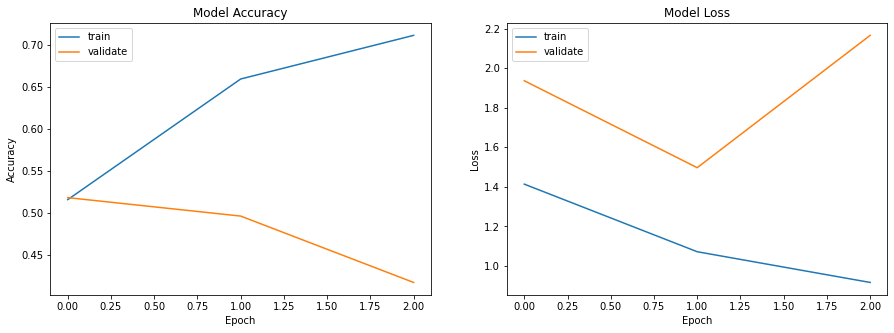

Confusion matrix, without normalization
Normalized confusion matrix


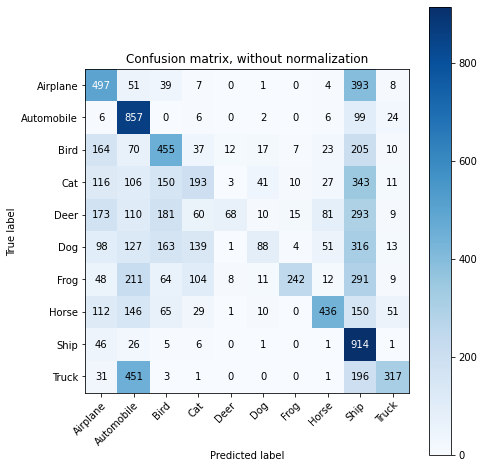

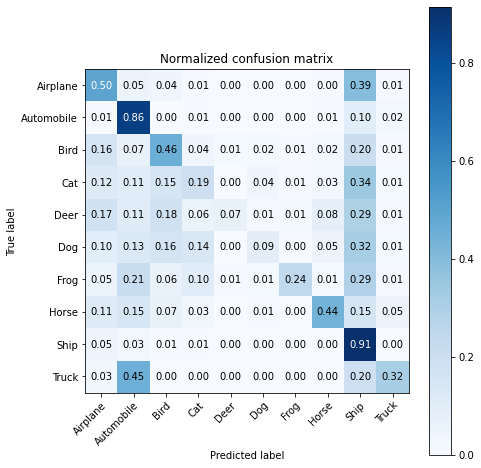

In [ ]:

class optional_2C:
    def __init__(self, x, y, y_val ,x_val , x_test, y_test, learn_rate,labels):
        self.x_train =x
        self.y_train =y
        self.y_val =y_val
        self.x_val =x_val
        self.x_test =x_test
        self.y_test =y_test
        self.learn_rate = learn_rate
        self.labels = labels

        self.buildWhole()

    def buildWhole(self):
        self.build()
        self.modelbuild()
        self.batchset()
        self.compileModel()
        self.plota()
        self.plotb()

    def build(self):
        self.base_model_4 = ResNet50(include_top=False,
                                weights='imagenet',
                                input_shape=(32,32,3),
                                classes=self.y_train.shape[1])

    def modelbuild(self):
        self.model_4=Sequential()
        #Add the Dense layers along with activation and batch normalization
        self.model_4.add(self.base_model_4)
        self.model_4.add(Flatten())

        #Add the Dense layers along with activation and batch normalization
        self.model_4.add(Dense(500,activation=('relu'),input_dim=512))
        self.model_4.add(Dense(500,activation=('relu')))
        self.model_4.add(Dense(500,activation=('relu')))
        self.model_4.add(Dense(500,activation=('relu')))
        self.model_4.add(Dense(500,activation=('relu')))
        self.model_4.add(Dense(500,activation=('relu')))
        self.model_4.add(Dense(500,activation=('relu')))
        self.model_4.add(Dense(500,activation=('relu')))

        self.model_4.add(Dense(10,activation=('softmax'))) #This is the classification layer

    def batchset(self):
        # Compile the model
        self.batch_size= 100
        self.epochs=3
        self.learn_rate=.001

        self.sgd=SGD(learning_rate=self.learn_rate,momentum=.9,nesterov=False)
        self.adam=Adam(learning_rate=self.learn_rate)

    def compileModel(self):
        self.model_4.compile(optimizer=self.adam,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


        # Train the model
        self.history_4 = self.model_4.fit(self.x_train, self.y_train,
                      batch_size=self.batch_size,
                      epochs=self.epochs,
                      validation_data=(self.x_val, self.y_val),
                      shuffle=True)
        # Score trained model.
        self.scores = model_4.evaluate(self.x_test, self.y_test, verbose=1)
        print('Test loss:', self.scores[0])
        print('Test accuracy:', self.scores[1])
        # make prediction.
        self.pred = self.model_4.predict(self.x_test)

        self.y_pred=self.model_4.predict_classes(self.x_test)
        self.y_true=np.argmax(self.y_test,axis=1)

        self.y_pred=self.model_4.predict_classes(self.x_test)
        self.y_true=np.argmax(self.y_test,axis=1)

        #Compute the confusion matrix
        self.confusion_mtx=confusion_matrix(self.y_true,self.y_pred)
        plotmodelhistory(self.history_4)
    def plota(self):

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(self.y_true, self.y_pred, classes=self.labels,
                              title='Confusion matrix, without normalization')

    def plotb(self):

        # Plot normalized confusion matrix
        plot_confusion_matrix(self.y_true, self.y_pred, classes=self.labels, normalize=True,
                              title='Normalized confusion matrix')

    def plot_confusion_matrix(y_true, y_pred, classes,
                            normalize=False,
                            title=None,
                            cmap=plt.cm.Blues):
      """
      This function prints and plots the confusion matrix.
      Normalization can be applied by setting `normalize=True`.
      """
      if not title:
          if normalize:
              title = 'Normalized confusion matrix'
          else:
              title = 'Confusion matrix, without normalization'

      # Compute confusion matrix
      cm = confusion_matrix(y_true, y_pred)
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')

  #     print(cm)

      fig, ax = plt.subplots(figsize=(7,7))
      im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
      ax.figure.colorbar(im, ax=ax)
      # We want to show all ticks...
      ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

      # Rotate the tick labels and set their alignment.
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")
      # Loop over data dimensions and create text annotations.
      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i in range(cm.shape[0]):
          for j in range(cm.shape[1]):
              ax.text(j, i, format(cm[i, j], fmt),
                      ha="center", va="center",
                      color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
      return ax


optional_2C(x_train,y_train,y_val,x_val, x_test, y_test, learn_rate,labels)

In [ ]:

import pkg_resources
installed_packages = pkg_resources.working_set
installed_packages_list = sorted(["%s==%s" % (i.key, i.version)
   for i in installed_packages])
print(installed_packages_list)
from platform import python_version

print(python_version())

['absl-py==0.12.0', 'alabaster==0.7.12', 'albumentations==0.1.12', 'altair==4.1.0', 'appdirs==1.4.4', 'argon2-cffi==20.1.0', 'arviz==0.11.2', 'astor==0.8.1', 'astropy==4.2.1', 'astunparse==1.6.3', 'async-generator==1.10', 'atari-py==0.2.9', 'atomicwrites==1.4.0', 'attrs==21.2.0', 'audioread==2.1.9', 'autograd==1.3', 'babel==2.9.1', 'backcall==0.2.0', 'beautifulsoup4==4.6.3', 'bleach==3.3.0', 'blis==0.4.1', 'bokeh==2.3.3', 'bottleneck==1.3.2', 'branca==0.4.2', 'bs4==0.0.1', 'cachecontrol==0.12.6', 'cached-property==1.5.2', 'cachetools==4.2.2', 'catalogue==1.0.0', 'certifi==2021.5.30', 'cffi==1.14.6', 'cftime==1.5.0', 'chardet==3.0.4', 'charset-normalizer==2.0.2', 'click==7.1.2', 'cloudpickle==1.3.0', 'cmake==3.12.0', 'cmdstanpy==0.9.5', 'colorcet==2.0.6', 'colorlover==0.3.0', 'community==1.0.0b1', 'contextlib2==0.5.5', 'convertdate==2.3.2', 'coverage==3.7.1', 'coveralls==0.5', 'crcmod==1.7', 'cufflinks==0.17.3', 'cupy-cuda101==9.1.0', 'cvxopt==1.2.6', 'cvxpy==1.0.31', 'cycler==0.10.0', 

QUESTION 2: Both attempts at transfer learning have resulted in rather disappointing results for validation/test accuracy. What seems to be the problem here?

Transfer learning has disappointing results test accuracy . I tried different techniques above in examples dog cat and birds were worst performing.Augmentaion helps training process and makes model more robust. I also attempted with new data nad got bad results.I also validated that when changing hyper parameters i can manippuilate performance in a way and fine tune things through batches size, node, activation functions, epochs and ect. I also attempted with even new learning rates.one of the problems I am seeing is  negative transfer. Transfer learning feels like it may only work if the first and last  are similar enouughh for the first epoch of training to be even be considered. Negative transfer learning displays the alot


### Summary table

| Method | Test accuracy | Remarks |
| --- | --- | --- |
| Baseline CNN | 0.752 | Bad at telling cats from dogs |
| Transfer learning using pre-trained CNN (ResNet50) | 0.769| Disappointly low, signs of overfitting |
| Model / variation of your choice | 0.744| Disappointly low, signs of overfitting |


### Conclusions

In conclusion transfer learning had a disappointing results. The problem of transfer learninng is when we attempt to train a model from beginning it takes heavy work to so. It means alot of effort to normalize the model so that it does not start overfitting too quickly. I realized this becomes worse when dataset is to small from horrible output examples above. I also notice on smaller data set transfer learning helps reduce over fitting. I think these exercises helped me get a better understanding of what transfer learning is how important datasets need to be related and what I can do to get better results.